# Notebook C: Funding Rates & Hyperliquid Analysis

## Learning Objectives
- Understand perpetual futures funding rate mechanics
- Analyze funding rates to identify market sentiment
- Calculate liquidation prices and risk management
- Integrate with Hyperliquid API for real-time data
- Visualize funding rate patterns and trading opportunities

---

## 1. Setup and Imports

In [1]:
# Import essential libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from typing import Dict, List, Tuple
import warnings
import time
import json

warnings.filterwarnings('ignore')

# Configure visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("tab10")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
%matplotlib inline

# Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.6f}'.format)

print("[SUCCESS] All libraries imported successfully")
print(f"Session started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

[SUCCESS] All libraries imported successfully
Session started: 2025-11-02 13:08:25


## 2. Funding Rate Theory

In [2]:
print("\n" + "="*80)
print("[THEORY] PERPETUAL FUTURES FUNDING RATE")
print("="*80)

print("""
What is a Funding Rate?
  • Periodic payment between longs and shorts (typically every 8 hours)
  • Purpose: Keep perpetual futures price anchored to spot price
  • Direction: Positive = Longs pay shorts, Negative = Shorts pay longs

Formula:
  Funding Rate = (Perp Price - Spot Price) / Spot Price
  Payment = Position Size × Funding Rate

Interpretation:
  • Positive funding (>0): Bullish sentiment, longs crowded
  • Negative funding (<0): Bearish sentiment, shorts crowded
  • High positive funding: Potential long squeeze risk
  • High negative funding: Potential short squeeze risk

Typical Ranges:
  • Neutral: -0.01% to +0.01% (8h rate)
  • Moderate: ±0.01% to ±0.05%
  • High: ±0.05% to ±0.1%
  • Extreme: >±0.1% (annualized >100%!)

Trading Strategy:
  • Funding arbitrage: Short when funding very positive (earn funding)
  • Contrarian: Fade extreme funding (expect mean reversion)
  • Trend following: Follow funding direction (momentum)
""")

print("="*80)


[THEORY] PERPETUAL FUTURES FUNDING RATE

What is a Funding Rate?
  • Periodic payment between longs and shorts (typically every 8 hours)
  • Purpose: Keep perpetual futures price anchored to spot price
  • Direction: Positive = Longs pay shorts, Negative = Shorts pay longs

Formula:
  Funding Rate = (Perp Price - Spot Price) / Spot Price
  Payment = Position Size × Funding Rate

Interpretation:
  • Positive funding (>0): Bullish sentiment, longs crowded
  • Negative funding (<0): Bearish sentiment, shorts crowded
  • High positive funding: Potential long squeeze risk
  • High negative funding: Potential short squeeze risk

Typical Ranges:
  • Neutral: -0.01% to +0.01% (8h rate)
  • Moderate: ±0.01% to ±0.05%
  • High: ±0.05% to ±0.1%
  • Extreme: >±0.1% (annualized >100%!)

Trading Strategy:
  • Funding arbitrage: Short when funding very positive (earn funding)
  • Contrarian: Fade extreme funding (expect mean reversion)
  • Trend following: Follow funding direction (momentum)



## 3. Liquidation Price Calculator

In [3]:
def calculate_liquidation_price(entry_price: float, leverage: float, 
                               position_type: str = 'long',
                               maintenance_margin: float = 0.005) -> Dict:
    """
    Calculate liquidation price for leveraged position.
    
    Args:
        entry_price: Entry price of position
        leverage: Leverage multiplier (e.g., 10 for 10x)
        position_type: 'long' or 'short'
        maintenance_margin: Minimum margin ratio (default 0.5%)
    
    Returns:
        Dictionary with liquidation details
    """
    initial_margin = 1 / leverage
    
    if position_type.lower() == 'long':
        # Long liquidation: price drops
        # Liquidation when: (entry - price) / entry = initial_margin - maintenance_margin
        liq_price = entry_price * (1 - initial_margin + maintenance_margin)
        price_drop_pct = ((entry_price - liq_price) / entry_price) * 100
    else:
        # Short liquidation: price rises
        liq_price = entry_price * (1 + initial_margin - maintenance_margin)
        price_drop_pct = ((liq_price - entry_price) / entry_price) * 100
    
    return {
        'entry_price': entry_price,
        'leverage': leverage,
        'position_type': position_type,
        'liquidation_price': liq_price,
        'price_move_%': price_drop_pct,
        'initial_margin_%': initial_margin * 100,
        'maintenance_margin_%': maintenance_margin * 100
    }

# Example calculations
print("\n[CALCULATOR] Liquidation Price Examples\n")

scenarios = [
    (50000, 5, 'long', 'BTC 5x Long'),
    (50000, 10, 'long', 'BTC 10x Long'),
    (50000, 25, 'long', 'BTC 25x Long'),
    (50000, 10, 'short', 'BTC 10x Short'),
]

for entry, lev, pos_type, label in scenarios:
    result = calculate_liquidation_price(entry, lev, pos_type)
    print(f"{label}:")
    print(f"  Entry: ${entry:,.0f}")
    print(f"  Liquidation: ${result['liquidation_price']:,.2f}")
    print(f"  Price move to liquidation: {result['price_move_%']:.2f}%\n")

print("="*80)


[CALCULATOR] Liquidation Price Examples

BTC 5x Long:
  Entry: $50,000
  Liquidation: $40,250.00
  Price move to liquidation: 19.50%

BTC 10x Long:
  Entry: $50,000
  Liquidation: $45,250.00
  Price move to liquidation: 9.50%

BTC 25x Long:
  Entry: $50,000
  Liquidation: $48,250.00
  Price move to liquidation: 3.50%

BTC 10x Short:
  Entry: $50,000
  Liquidation: $54,750.00
  Price move to liquidation: 9.50%



## 4. Hyperliquid API Integration (Simulated Data)

In [4]:
# Note: Hyperliquid API endpoints (public, no auth needed for public data)
# Real API: https://api.hyperliquid.xyz/info
# For this notebook, we'll simulate data structure

def simulate_hyperliquid_funding_rates() -> pd.DataFrame:
    """
    Simulate Hyperliquid funding rate data.
    In production, this would call: POST https://api.hyperliquid.xyz/info
    with body: {"type": "metaAndAssetCtxs"}
    """
    # Simulated data for major assets
    assets = [
        {'symbol': 'BTC', 'funding_rate': 0.0025, 'open_interest': 1250000000, 'volume_24h': 850000000, 'mark_price': 50000},
        {'symbol': 'ETH', 'funding_rate': 0.0018, 'open_interest': 650000000, 'volume_24h': 420000000, 'mark_price': 3000},
        {'symbol': 'SOL', 'funding_rate': 0.0042, 'open_interest': 180000000, 'volume_24h': 95000000, 'mark_price': 110},
        {'symbol': 'ARB', 'funding_rate': -0.0015, 'open_interest': 45000000, 'volume_24h': 22000000, 'mark_price': 1.2},
        {'symbol': 'AVAX', 'funding_rate': 0.0008, 'open_interest': 75000000, 'volume_24h': 38000000, 'mark_price': 35},
        {'symbol': 'MATIC', 'funding_rate': -0.0022, 'open_interest': 62000000, 'volume_24h': 31000000, 'mark_price': 0.8},
        {'symbol': 'DOGE', 'funding_rate': 0.0055, 'open_interest': 95000000, 'volume_24h': 58000000, 'mark_price': 0.08},
        {'symbol': 'LINK', 'funding_rate': 0.0012, 'open_interest': 52000000, 'volume_24h': 27000000, 'mark_price': 15},
        {'symbol': 'APT', 'funding_rate': 0.0035, 'open_interest': 38000000, 'volume_24h': 19000000, 'mark_price': 8.5},
        {'symbol': 'SUI', 'funding_rate': 0.0068, 'open_interest': 42000000, 'volume_24h': 24000000, 'mark_price': 1.5},
    ]
    
    df = pd.DataFrame(assets)
    
    # Calculate annualized funding rate (8h rate × 3 per day × 365 days)
    df['funding_rate_8h_%'] = df['funding_rate'] * 100
    df['funding_rate_annual_%'] = df['funding_rate'] * 3 * 365 * 100
    
    # Calculate market metrics
    df['oi_to_volume'] = df['open_interest'] / df['volume_24h']
    
    return df

# Simulate historical funding rates
def simulate_historical_funding(symbol: str = 'BTC', days: int = 30) -> pd.DataFrame:
    """
    Simulate 30 days of historical funding rates (8-hour intervals).
    """
    periods = days * 3  # 3 funding payments per day
    dates = pd.date_range(end=datetime.now(), periods=periods, freq='8H')
    
    # Simulate funding rates with some autocorrelation
    np.random.seed(42)  # For reproducibility
    base_rate = 0.002
    noise = np.random.randn(periods) * 0.002
    trend = np.linspace(0, 0.003, periods)  # Slight upward trend
    
    funding_rates = base_rate + noise + trend * np.sin(np.linspace(0, 4*np.pi, periods))
    
    # Simulate price (correlated with funding)
    if symbol == 'BTC':
        base_price = 48000
        price = base_price + np.cumsum(np.random.randn(periods) * 500)
    elif symbol == 'ETH':
        base_price = 2800
        price = base_price + np.cumsum(np.random.randn(periods) * 30)
    else:
        base_price = 100
        price = base_price + np.cumsum(np.random.randn(periods) * 5)
    
    df = pd.DataFrame({
        'timestamp': dates,
        'symbol': symbol,
        'funding_rate': funding_rates,
        'funding_rate_%': funding_rates * 100,
        'funding_rate_annual_%': funding_rates * 3 * 365 * 100,
        'mark_price': price
    })
    
    return df

# Fetch current data
print("\n[DATA] Fetching current Hyperliquid funding rates (simulated)...\n")
df_funding = simulate_hyperliquid_funding_rates()

print("Current Funding Rates:\n")
print(df_funding[['symbol', 'funding_rate_8h_%', 'funding_rate_annual_%', 
                   'open_interest', 'volume_24h', 'mark_price']].to_string(index=False))

print("\n" + "="*80)


[DATA] Fetching current Hyperliquid funding rates (simulated)...

Current Funding Rates:

symbol  funding_rate_8h_%  funding_rate_annual_%  open_interest  volume_24h   mark_price
   BTC           0.250000             273.750000     1250000000   850000000 50000.000000
   ETH           0.180000             197.100000      650000000   420000000  3000.000000
   SOL           0.420000             459.900000      180000000    95000000   110.000000
   ARB          -0.150000            -164.250000       45000000    22000000     1.200000
  AVAX           0.080000              87.600000       75000000    38000000    35.000000
 MATIC          -0.220000            -240.900000       62000000    31000000     0.800000
  DOGE           0.550000             602.250000       95000000    58000000     0.080000
  LINK           0.120000             131.400000       52000000    27000000    15.000000
   APT           0.350000             383.250000       38000000    19000000     8.500000
   SUI           0.

## 5. VISUALIZATION 1: Current Funding Rates (3 Charts)

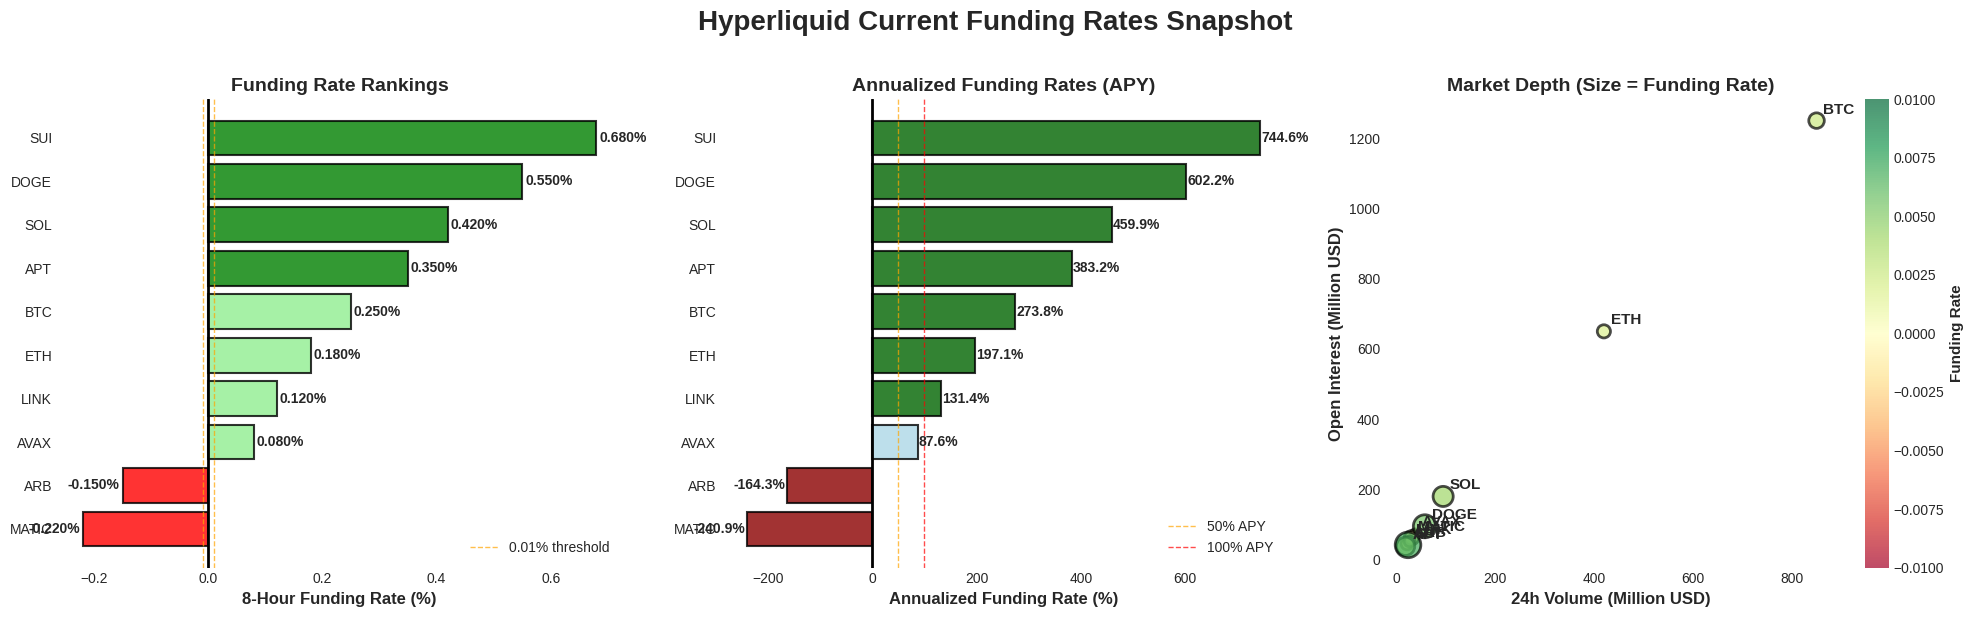


[VISUALIZATION 1] Current funding rates complete!


In [5]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Hyperliquid Current Funding Rates Snapshot', 
             fontsize=20, fontweight='bold', y=1.02)

# Plot 1: Funding Rate Rankings
ax1 = axes[0]
df_sorted = df_funding.sort_values('funding_rate_8h_%')
colors = ['red' if x < 0 else 'green' if x > 0.003 else 'lightgreen' 
          for x in df_sorted['funding_rate']]

bars = ax1.barh(df_sorted['symbol'], df_sorted['funding_rate_8h_%'], 
                color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.axvline(x=0, color='black', linestyle='-', linewidth=2)
ax1.axvline(x=0.01, color='orange', linestyle='--', linewidth=1, alpha=0.7, label='0.01% threshold')
ax1.axvline(x=-0.01, color='orange', linestyle='--', linewidth=1, alpha=0.7)

ax1.set_xlabel('8-Hour Funding Rate (%)', fontsize=12, fontweight='bold')
ax1.set_title('Funding Rate Rankings', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(True, alpha=0.3, axis='x')

for bar, rate in zip(bars, df_sorted['funding_rate_8h_%']):
    width = bar.get_width()
    label_x = width + 0.005 if width > 0 else width - 0.005
    ha = 'left' if width > 0 else 'right'
    ax1.text(label_x, bar.get_y() + bar.get_height()/2.,
             f'{rate:.3f}%', ha=ha, va='center', fontweight='bold', fontsize=10)

# Plot 2: Annualized Funding Rate
ax2 = axes[1]
df_sorted2 = df_funding.sort_values('funding_rate_annual_%')
colors2 = ['darkred' if x < 0 else 'darkgreen' if x > 100 else 'lightblue' 
           for x in df_sorted2['funding_rate_annual_%']]

bars2 = ax2.barh(df_sorted2['symbol'], df_sorted2['funding_rate_annual_%'], 
                 color=colors2, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.axvline(x=0, color='black', linestyle='-', linewidth=2)
ax2.axvline(x=50, color='orange', linestyle='--', linewidth=1, alpha=0.7, label='50% APY')
ax2.axvline(x=100, color='red', linestyle='--', linewidth=1, alpha=0.7, label='100% APY')

ax2.set_xlabel('Annualized Funding Rate (%)', fontsize=12, fontweight='bold')
ax2.set_title('Annualized Funding Rates (APY)', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right', fontsize=10)
ax2.grid(True, alpha=0.3, axis='x')

for bar, rate in zip(bars2, df_sorted2['funding_rate_annual_%']):
    width = bar.get_width()
    label_x = width + 2 if width > 0 else width - 2
    ha = 'left' if width > 0 else 'right'
    ax2.text(label_x, bar.get_y() + bar.get_height()/2.,
             f'{rate:.1f}%', ha=ha, va='center', fontweight='bold', fontsize=10)

# Plot 3: OI vs Volume (Bubble chart)
ax3 = axes[2]
scatter = ax3.scatter(df_funding['volume_24h']/1e6, 
                     df_funding['open_interest']/1e6,
                     s=np.abs(df_funding['funding_rate'])*50000,
                     c=df_funding['funding_rate'],
                     cmap='RdYlGn',
                     alpha=0.7,
                     edgecolors='black',
                     linewidth=2,
                     vmin=-0.01,
                     vmax=0.01)

for idx, row in df_funding.iterrows():
    ax3.annotate(row['symbol'], 
                (row['volume_24h']/1e6, row['open_interest']/1e6),
                xytext=(5, 5), textcoords='offset points',
                fontsize=11, fontweight='bold')

ax3.set_xlabel('24h Volume (Million USD)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Open Interest (Million USD)', fontsize=12, fontweight='bold')
ax3.set_title('Market Depth (Size = Funding Rate)', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('Funding Rate', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n[VISUALIZATION 1] Current funding rates complete!")

## 6. Historical Funding Rate Analysis

In [6]:
# Fetch historical data for major assets
print("\n[DATA] Fetching 30-day funding rate history (simulated)...\n")

hist_btc = simulate_historical_funding('BTC', days=30)
hist_eth = simulate_historical_funding('ETH', days=30)
hist_sol = simulate_historical_funding('SOL', days=30)

# Combine
df_hist = pd.concat([hist_btc, hist_eth, hist_sol], ignore_index=True)

print(f"[SUCCESS] Fetched {len(df_hist)} funding rate data points")
print(f"Assets: {df_hist['symbol'].unique()}")
print(f"Date range: {df_hist['timestamp'].min()} to {df_hist['timestamp'].max()}")

# Calculate summary statistics
print("\n[STATISTICS] 30-Day Funding Rate Summary\n")
for symbol in df_hist['symbol'].unique():
    data = df_hist[df_hist['symbol'] == symbol]
    print(f"{symbol}:")
    print(f"  Mean 8h Rate: {data['funding_rate_%'].mean():.4f}%")
    print(f"  Median: {data['funding_rate_%'].median():.4f}%")
    print(f"  Std Dev: {data['funding_rate_%'].std():.4f}%")
    print(f"  Min: {data['funding_rate_%'].min():.4f}%")
    print(f"  Max: {data['funding_rate_%'].max():.4f}%")
    print(f"  Annualized Mean: {data['funding_rate_annual_%'].mean():.1f}%\n")

print("="*80)


[DATA] Fetching 30-day funding rate history (simulated)...

[SUCCESS] Fetched 270 funding rate data points
Assets: ['BTC' 'ETH' 'SOL']
Date range: 2025-10-03 21:08:26.412404 to 2025-11-02 13:08:26.425886

[STATISTICS] 30-Day Funding Rate Summary

BTC:
  Mean 8h Rate: 0.1567%
  Median: 0.1622%
  Std Dev: 0.2243%
  Min: -0.5370%
  Max: 0.5835%
  Annualized Mean: 171.6%

ETH:
  Mean 8h Rate: 0.1567%
  Median: 0.1622%
  Std Dev: 0.2243%
  Min: -0.5370%
  Max: 0.5835%
  Annualized Mean: 171.6%

SOL:
  Mean 8h Rate: 0.1567%
  Median: 0.1622%
  Std Dev: 0.2243%
  Min: -0.5370%
  Max: 0.5835%
  Annualized Mean: 171.6%



## 7. VISUALIZATION 2: Historical Funding Analysis (3 Charts)

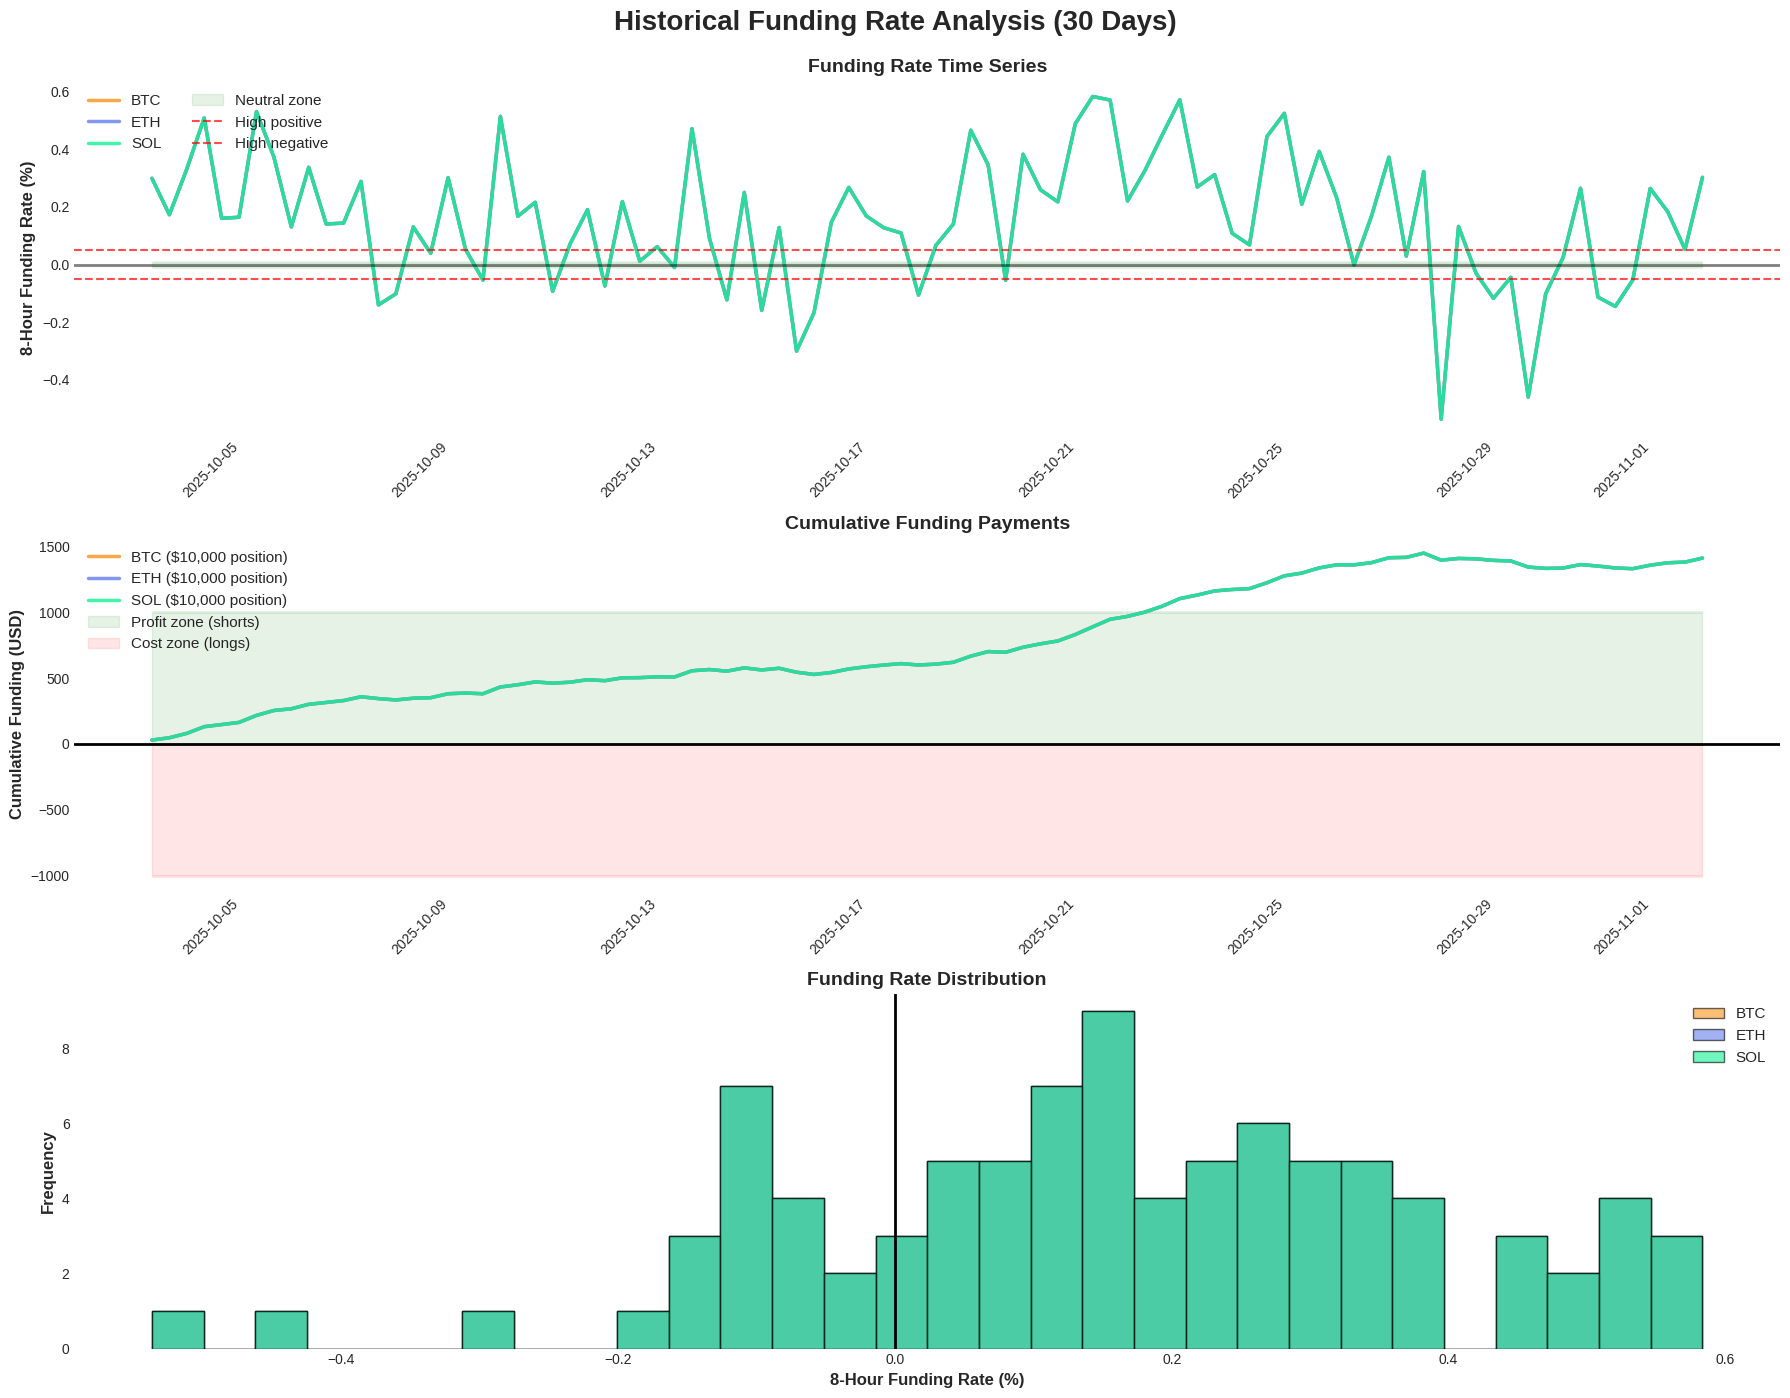


[VISUALIZATION 2] Historical funding analysis complete!


In [7]:
fig, axes = plt.subplots(3, 1, figsize=(18, 14))
fig.suptitle('Historical Funding Rate Analysis (30 Days)', 
             fontsize=20, fontweight='bold', y=0.995)

colors_assets = {'BTC': '#f7931a', 'ETH': '#627eea', 'SOL': '#14f195'}

# Plot 1: Funding Rate Time Series
ax1 = axes[0]
for symbol in df_hist['symbol'].unique():
    data = df_hist[df_hist['symbol'] == symbol]
    ax1.plot(data['timestamp'], data['funding_rate_%'], 
            label=symbol, linewidth=2.5, alpha=0.8, color=colors_assets[symbol])

ax1.axhline(y=0, color='black', linestyle='-', linewidth=2, alpha=0.5)
ax1.fill_between(df_hist['timestamp'].unique(), -0.01, 0.01, alpha=0.1, color='green', label='Neutral zone')
ax1.axhline(y=0.05, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='High positive')
ax1.axhline(y=-0.05, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='High negative')

ax1.set_ylabel('8-Hour Funding Rate (%)', fontsize=12, fontweight='bold')
ax1.set_title('Funding Rate Time Series', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=11, ncol=2)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Cumulative Funding Paid/Received
ax2 = axes[1]
for symbol in df_hist['symbol'].unique():
    data = df_hist[df_hist['symbol'] == symbol].copy()
    # Cumulative funding (what a $10,000 position would pay/receive)
    position_size = 10000
    data['cumulative_funding'] = (data['funding_rate'] * position_size).cumsum()
    
    ax2.plot(data['timestamp'], data['cumulative_funding'], 
            label=f"{symbol} (${position_size:,} position)", 
            linewidth=2.5, alpha=0.8, color=colors_assets[symbol])

ax2.axhline(y=0, color='black', linestyle='-', linewidth=2)
ax2.fill_between(df_hist['timestamp'].unique(), 0, 1000, alpha=0.1, color='green', label='Profit zone (shorts)')
ax2.fill_between(df_hist['timestamp'].unique(), -1000, 0, alpha=0.1, color='red', label='Cost zone (longs)')

ax2.set_ylabel('Cumulative Funding (USD)', fontsize=12, fontweight='bold')
ax2.set_title('Cumulative Funding Payments', fontsize=14, fontweight='bold')
ax2.legend(loc='upper left', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Distribution of Funding Rates
ax3 = axes[2]
for symbol in df_hist['symbol'].unique():
    data = df_hist[df_hist['symbol'] == symbol]
    ax3.hist(data['funding_rate_%'], bins=30, alpha=0.6, 
            label=symbol, color=colors_assets[symbol], edgecolor='black')

ax3.axvline(x=0, color='black', linestyle='-', linewidth=2)
ax3.set_xlabel('8-Hour Funding Rate (%)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax3.set_title('Funding Rate Distribution', fontsize=14, fontweight='bold')
ax3.legend(loc='upper right', fontsize=11)
ax3.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n[VISUALIZATION 2] Historical funding analysis complete!")

## 8. Funding Rate vs Price Correlation

In [8]:
# Calculate correlation between funding and price changes
print("\n[ANALYSIS] Funding Rate vs Price Movement Correlation\n")

for symbol in df_hist['symbol'].unique():
    data = df_hist[df_hist['symbol'] == symbol].copy()
    
    # Calculate price returns
    data['price_return_%'] = data['mark_price'].pct_change() * 100
    
    # Correlation
    corr = data['funding_rate_%'].corr(data['price_return_%'])
    
    # Lagged correlation (does funding predict future price?)
    data['funding_lag1'] = data['funding_rate_%'].shift(1)
    corr_lag = data['funding_lag1'].corr(data['price_return_%'])
    
    print(f"{symbol}:")
    print(f"  Correlation (funding vs price): {corr:.3f}")
    print(f"  Lagged correlation (funding predicts price): {corr_lag:.3f}")
    
    # High funding periods
    high_funding = data[data['funding_rate_%'] > data['funding_rate_%'].quantile(0.75)]
    mean_return_high_funding = high_funding['price_return_%'].mean()
    
    print(f"  Avg price change during high funding: {mean_return_high_funding:.3f}%\n")

print("="*80)


[ANALYSIS] Funding Rate vs Price Movement Correlation

BTC:
  Correlation (funding vs price): -0.100
  Lagged correlation (funding predicts price): 0.113
  Avg price change during high funding: 0.045%

ETH:
  Correlation (funding vs price): -0.100
  Lagged correlation (funding predicts price): 0.113
  Avg price change during high funding: 0.046%

SOL:
  Correlation (funding vs price): -0.104
  Lagged correlation (funding predicts price): 0.114
  Avg price change during high funding: 0.221%



## 9. VISUALIZATION 3: Trading Insights (4 Charts)

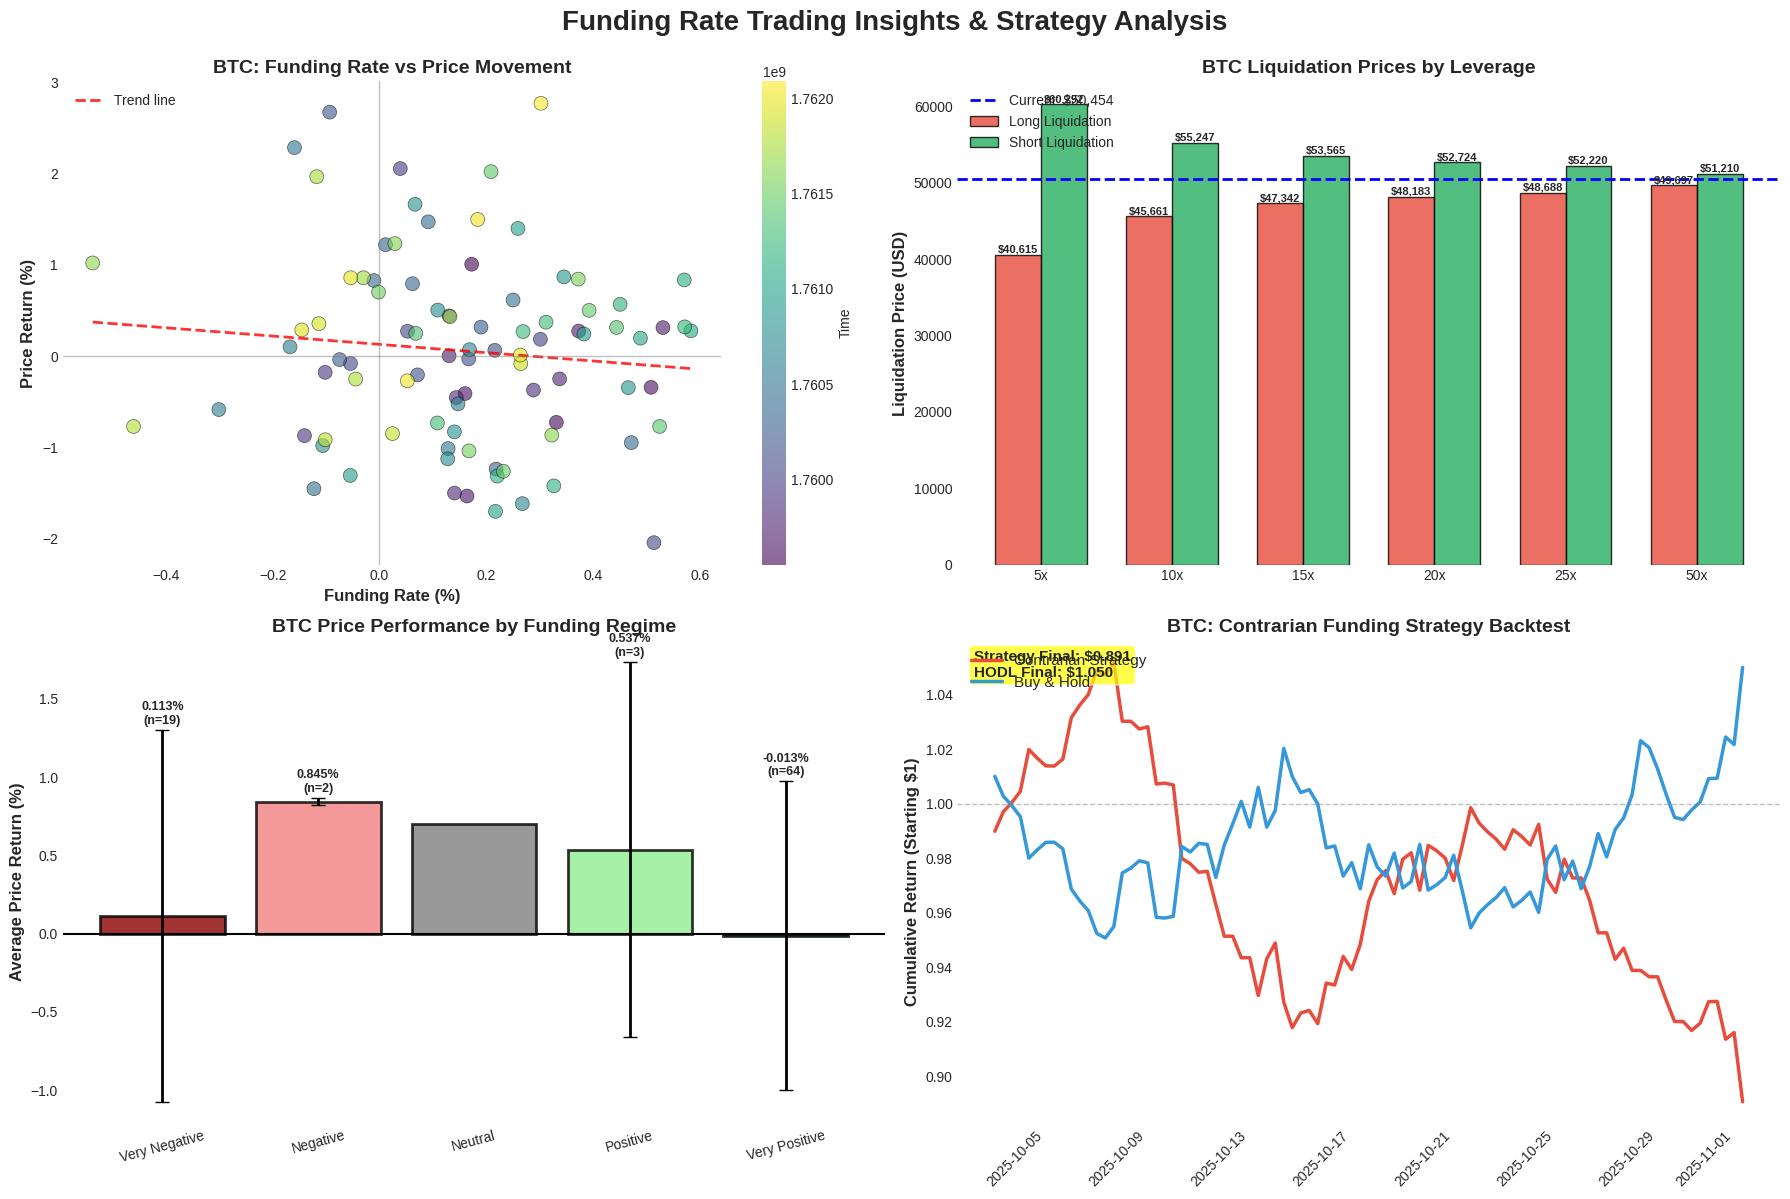


[VISUALIZATION 3] Trading insights complete!


In [10]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Funding Rate Trading Insights & Strategy Analysis', 
             fontsize=20, fontweight='bold', y=0.995)

# Focus on BTC for detailed analysis
btc_data = df_hist[df_hist['symbol'] == 'BTC'].copy()
btc_data['price_return_%'] = btc_data['mark_price'].pct_change() * 100

# Plot 1: Funding vs Price Scatter
ax1 = axes[0, 0]
scatter = ax1.scatter(btc_data['funding_rate_%'], btc_data['price_return_%'],
                     s=100, alpha=0.6, c=btc_data['timestamp'].astype(int)/1e9,
                     cmap='viridis', edgecolors='black', linewidth=0.5)

# Add regression line - FIX: Drop NaN from both arrays together
valid_data = btc_data[['funding_rate_%', 'price_return_%']].dropna()
if len(valid_data) > 1:  # Need at least 2 points for regression
    z = np.polyfit(valid_data['funding_rate_%'], valid_data['price_return_%'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(valid_data['funding_rate_%'].min(), valid_data['funding_rate_%'].max(), 100)
    ax1.plot(x_line, p(x_line), "r--", linewidth=2, alpha=0.8, label=f'Trend line')

ax1.axhline(y=0, color='gray', linestyle='-', linewidth=1, alpha=0.5)
ax1.axvline(x=0, color='gray', linestyle='-', linewidth=1, alpha=0.5)
ax1.set_xlabel('Funding Rate (%)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Price Return (%)', fontsize=12, fontweight='bold')
ax1.set_title('BTC: Funding Rate vs Price Movement', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax1)
cbar.set_label('Time', fontsize=10)

# Plot 2: Liquidation Risk Heatmap
ax2 = axes[0, 1]
leverages = [5, 10, 15, 20, 25, 50]
current_price = btc_data['mark_price'].iloc[-1]

liq_long = []
liq_short = []
for lev in leverages:
    liq_l = calculate_liquidation_price(current_price, lev, 'long')['liquidation_price']
    liq_s = calculate_liquidation_price(current_price, lev, 'short')['liquidation_price']
    liq_long.append(liq_l)
    liq_short.append(liq_s)

x_pos = np.arange(len(leverages))
width = 0.35

bars1 = ax2.bar(x_pos - width/2, liq_long, width, label='Long Liquidation', 
               color='#e74c3c', alpha=0.8, edgecolor='black')
bars2 = ax2.bar(x_pos + width/2, liq_short, width, label='Short Liquidation', 
               color='#27ae60', alpha=0.8, edgecolor='black')
ax2.axhline(y=current_price, color='blue', linestyle='--', linewidth=2, 
           label=f'Current: ${current_price:,.0f}')

ax2.set_ylabel('Liquidation Price (USD)', fontsize=12, fontweight='bold')
ax2.set_title('BTC Liquidation Prices by Leverage', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f'{l}x' for l in leverages])
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'${height:,.0f}', ha='center', va='bottom', 
                fontsize=8, fontweight='bold')

# Plot 3: Funding Rate Regime Analysis
ax3 = axes[1, 0]
# Categorize funding into regimes
btc_data['regime'] = pd.cut(btc_data['funding_rate_%'], 
                            bins=[-np.inf, -0.03, -0.01, 0.01, 0.03, np.inf],
                            labels=['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive'])

regime_returns = btc_data.groupby('regime')['price_return_%'].agg(['mean', 'std', 'count'])

colors_regime = ['darkred', 'lightcoral', 'gray', 'lightgreen', 'darkgreen']
bars3 = ax3.bar(range(len(regime_returns)), regime_returns['mean'], 
               yerr=regime_returns['std'], color=colors_regime, alpha=0.8,
               edgecolor='black', linewidth=2,
               error_kw={'linewidth': 2, 'ecolor': 'black', 'capsize': 5})

ax3.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
ax3.set_xticks(range(len(regime_returns)))
ax3.set_xticklabels(regime_returns.index, fontsize=10, rotation=15)
ax3.set_ylabel('Average Price Return (%)', fontsize=12, fontweight='bold')
ax3.set_title('BTC Price Performance by Funding Regime', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

for bar, (idx, row) in zip(bars3, regime_returns.iterrows()):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + row['std'] + 0.02,
            f"{row['mean']:.3f}%\n(n={int(row['count'])})",
            ha='center', va='bottom', fontweight='bold', fontsize=9)

# Plot 4: Strategy Backtest (Simple)
ax4 = axes[1, 1]
# Strategy: Short when funding > 0.05%, Long when funding < -0.05%
btc_data['signal'] = 0
btc_data.loc[btc_data['funding_rate_%'] > 0.05, 'signal'] = -1  # Short (contrarian)
btc_data.loc[btc_data['funding_rate_%'] < -0.05, 'signal'] = 1  # Long (contrarian)

btc_data['strategy_return'] = btc_data['signal'].shift(1) * btc_data['price_return_%']
btc_data['cumulative_strategy'] = (1 + btc_data['strategy_return']/100).cumprod()
btc_data['cumulative_hodl'] = (1 + btc_data['price_return_%']/100).cumprod()

ax4.plot(btc_data['timestamp'], btc_data['cumulative_strategy'], 
        linewidth=2.5, label='Contrarian Strategy', color='#e74c3c')
ax4.plot(btc_data['timestamp'], btc_data['cumulative_hodl'], 
        linewidth=2.5, label='Buy & Hold', color='#3498db')
ax4.axhline(y=1, color='gray', linestyle='--', linewidth=1, alpha=0.5)

ax4.set_ylabel('Cumulative Return (Starting $1)', fontsize=12, fontweight='bold')
ax4.set_title('BTC: Contrarian Funding Strategy Backtest', fontsize=14, fontweight='bold')
ax4.legend(loc='upper left', fontsize=11)
ax4.grid(True, alpha=0.3)
ax4.tick_params(axis='x', rotation=45)

# Add final values
final_strategy = btc_data['cumulative_strategy'].iloc[-1]
final_hodl = btc_data['cumulative_hodl'].iloc[-1]
ax4.text(0.02, 0.98, f'Strategy Final: ${final_strategy:.3f}\nHODL Final: ${final_hodl:.3f}',
        transform=ax4.transAxes, fontsize=11, fontweight='bold',
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.show()

print("\n[VISUALIZATION 3] Trading insights complete!")

## 10. Summary & Trading Strategies

In [11]:
print("\n" + "="*80)
print("[SUMMARY] FUNDING RATES & HYPERLIQUID - KEY TAKEAWAYS")
print("="*80)

print("\n[CURRENT MARKET SNAPSHOT]")
most_positive = df_funding.nlargest(1, 'funding_rate_8h_%').iloc[0]
most_negative = df_funding.nsmallest(1, 'funding_rate_8h_%').iloc[0]

print(f"  Highest funding: {most_positive['symbol']} at {most_positive['funding_rate_8h_%']:.3f}% (8h)")
print(f"    → Annualized: {most_positive['funding_rate_annual_%']:.1f}% APY")
print(f"    → Interpretation: Very bullish, longs crowded, consider shorting")

print(f"\n  Lowest funding: {most_negative['symbol']} at {most_negative['funding_rate_8h_%']:.3f}% (8h)")
print(f"    → Annualized: {most_negative['funding_rate_annual_%']:.1f}% APY")
print(f"    → Interpretation: Bearish, shorts crowded, consider longing")

print("\n[LIQUIDATION RISKS]")
current_btc = 50000  # Example
for lev in [5, 10, 20, 50]:
    liq_long = calculate_liquidation_price(current_btc, lev, 'long')
    print(f"  {lev}x Long: Liquidated if BTC drops to ${liq_long['liquidation_price']:,.2f} ({liq_long['price_move_%']:.2f}% drop)")

print("\n[TRADING STRATEGIES]")
print("\n1. FUNDING RATE ARBITRAGE (Market Neutral)")
print("   • Setup: Short perp when funding very positive, hedge with spot long")
print("   • Profit: Earn funding payments (shorts receive when funding positive)")
print("   • Risk: Basis risk, liquidation if leverage too high")
print("   • Example: BTC funding at 0.1% (8h) = 109% APY")

print("\n2. CONTRARIAN MEAN REVERSION")
print("   • Setup: Fade extreme funding rates")
print("   • Long when funding very negative (shorts crowded → squeeze risk)")
print("   • Short when funding very positive (longs crowded → dump risk)")
print("   • Threshold: ±0.05% (8h) or ±55% annualized")

print("\n3. TREND FOLLOWING")
print("   • Setup: Follow funding direction as momentum indicator")
print("   • Positive funding + rising = Strong uptrend (join longs)")
print("   • Negative funding + falling = Strong downtrend (join shorts)")
print("   • Warning: Expensive to hold if wrong (pay high funding)")

print("\n4. LEVERAGE MANAGEMENT")
print("   • Rule 1: Never use max leverage (50x = 2% move liquidates you)")
print("   • Rule 2: Keep leverage under 10x for beginners")
print("   • Rule 3: Use stop-losses ALWAYS (set at -5% to -10%)")
print("   • Rule 4: Monitor funding costs (high funding eats profits)")
print("   • Rule 5: Size positions: Risk only 1-2% of capital per trade")

print("\n[HYPERLIQUID SPECIFICS]")
print("  • Orderbook-based (not AMM) = Better price execution")
print("  • 0.0025% maker rebate, 0.035% taker fee")
print("  • Up to 50x leverage (but don't use it all!)")
print("  • No KYC required (fully permissionless)")
print("  • HLP vault: Earn from being counterparty to traders")

print("\n[RISK WARNINGS]")
print("  ⚠️  High leverage amplifies both gains AND losses")
print("  ⚠️  Liquidations are final - you lose your collateral")
print("  ⚠️  Funding rates can stay extreme longer than you can stay solvent")
print("  ⚠️  Always have a liquidation plan and stop-loss")
print("  ⚠️  Start small: Practice with 0.1-1% of portfolio")

print("\n" + "="*80)
print("[COMPLETE] Notebook C: Funding Rates & Hyperliquid Analysis")
print("="*80)
print(f"\nSession completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("\nNext: Notebook D - Portfolio Optimization (Homework)")


[SUMMARY] FUNDING RATES & HYPERLIQUID - KEY TAKEAWAYS

[CURRENT MARKET SNAPSHOT]
  Highest funding: SUI at 0.680% (8h)
    → Annualized: 744.6% APY
    → Interpretation: Very bullish, longs crowded, consider shorting

  Lowest funding: MATIC at -0.220% (8h)
    → Annualized: -240.9% APY
    → Interpretation: Bearish, shorts crowded, consider longing

[LIQUIDATION RISKS]
  5x Long: Liquidated if BTC drops to $40,250.00 (19.50% drop)
  10x Long: Liquidated if BTC drops to $45,250.00 (9.50% drop)
  20x Long: Liquidated if BTC drops to $47,750.00 (4.50% drop)
  50x Long: Liquidated if BTC drops to $49,250.00 (1.50% drop)

[TRADING STRATEGIES]

1. FUNDING RATE ARBITRAGE (Market Neutral)
   • Setup: Short perp when funding very positive, hedge with spot long
   • Profit: Earn funding payments (shorts receive when funding positive)
   • Risk: Basis risk, liquidation if leverage too high
   • Example: BTC funding at 0.1% (8h) = 109% APY

2. CONTRARIAN MEAN REVERSION
   • Setup: Fade extreme f